# Sciplex Dose

In [1]:
ood_seed = 11

In [2]:
num_ood = 1

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

52

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('SAHA', '10.0'), 426)


Removed datapoint: 426

train         11492
validation     2893
ood             426
Name: split, dtype: int64

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="condition",
    control_group="Vehicle",
    dosage_key="dose_val",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['cell_type']
)

  0%|          | 0/14811 [00:00<?, ?it/s]

 61%|██████    | 9055/14811 [00:00<00:00, 90539.08it/s]

100%|██████████| 14811/14811 [00:00<00:00, 91499.75it/s]

  0%|          | 0/14811 [00:00<?, ?it/s]

100%|██████████| 14811/14811 [00:00<00:00, 925010.22it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [13]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [14]:
model.train(max_epochs=400)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 164.06it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:03<26:02,  3.92s/it]

Epoch 1/400:   0%|          | 1/400 [00:03<26:02,  3.92s/it, v_num=1, recon=3.07e+3, r2_mean=0.127, adv_loss=1.55, acc_pert=0.297]

Epoch 2/400:   0%|          | 1/400 [00:03<26:02,  3.92s/it, v_num=1, recon=3.07e+3, r2_mean=0.127, adv_loss=1.55, acc_pert=0.297]

Epoch 2/400:   0%|          | 2/400 [00:07<23:46,  3.58s/it, v_num=1, recon=3.07e+3, r2_mean=0.127, adv_loss=1.55, acc_pert=0.297]

Epoch 2/400:   0%|          | 2/400 [00:07<23:46,  3.58s/it, v_num=1, recon=2.34e+3, r2_mean=0.482, adv_loss=1.31, acc_pert=0.494]

Epoch 3/400:   0%|          | 2/400 [00:07<23:46,  3.58s/it, v_num=1, recon=2.34e+3, r2_mean=0.482, adv_loss=1.31, acc_pert=0.494]

Epoch 3/400:   1%|          | 3/400 [00:10<22:57,  3.47s/it, v_num=1, recon=2.34e+3, r2_mean=0.482, adv_loss=1.31, acc_pert=0.494]

Epoch 3/400:   1%|          | 3/400 [00:10<22:57,  3.47s/it, v_num=1, recon=2.19e+3, r2_mean=0.597, adv_loss=1.16, acc_pert=0.566]

Epoch 4/400:   1%|          | 3/400 [00:10<22:57,  3.47s/it, v_num=1, recon=2.19e+3, r2_mean=0.597, adv_loss=1.16, acc_pert=0.566]

Epoch 4/400:   1%|          | 4/400 [00:13<22:34,  3.42s/it, v_num=1, recon=2.19e+3, r2_mean=0.597, adv_loss=1.16, acc_pert=0.566]

Epoch 4/400:   1%|          | 4/400 [00:13<22:34,  3.42s/it, v_num=1, recon=2.14e+3, r2_mean=0.666, adv_loss=1.08, acc_pert=0.6]  

Epoch 5/400:   1%|          | 4/400 [00:13<22:34,  3.42s/it, v_num=1, recon=2.14e+3, r2_mean=0.666, adv_loss=1.08, acc_pert=0.6]

Epoch 5/400:   1%|▏         | 5/400 [00:17<22:15,  3.38s/it, v_num=1, recon=2.14e+3, r2_mean=0.666, adv_loss=1.08, acc_pert=0.6]

Epoch 5/400:   1%|▏         | 5/400 [00:17<22:15,  3.38s/it, v_num=1, recon=2.12e+3, r2_mean=0.709, adv_loss=1.01, acc_pert=0.628]

Epoch 6/400:   1%|▏         | 5/400 [00:17<22:15,  3.38s/it, v_num=1, recon=2.12e+3, r2_mean=0.709, adv_loss=1.01, acc_pert=0.628]

Epoch 6/400:   2%|▏         | 6/400 [00:21<24:29,  3.73s/it, v_num=1, recon=2.12e+3, r2_mean=0.709, adv_loss=1.01, acc_pert=0.628]

Epoch 6/400:   2%|▏         | 6/400 [00:21<24:29,  3.73s/it, v_num=1, recon=2.11e+3, r2_mean=0.738, adv_loss=0.965, acc_pert=0.65]

Epoch 7/400:   2%|▏         | 6/400 [00:21<24:29,  3.73s/it, v_num=1, recon=2.11e+3, r2_mean=0.738, adv_loss=0.965, acc_pert=0.65]

Epoch 7/400:   2%|▏         | 7/400 [00:25<23:35,  3.60s/it, v_num=1, recon=2.11e+3, r2_mean=0.738, adv_loss=0.965, acc_pert=0.65]

Epoch 7/400:   2%|▏         | 7/400 [00:25<23:35,  3.60s/it, v_num=1, recon=2.1e+3, r2_mean=0.762, adv_loss=0.935, acc_pert=0.656]

Epoch 8/400:   2%|▏         | 7/400 [00:25<23:35,  3.60s/it, v_num=1, recon=2.1e+3, r2_mean=0.762, adv_loss=0.935, acc_pert=0.656]

Epoch 8/400:   2%|▏         | 8/400 [00:28<22:59,  3.52s/it, v_num=1, recon=2.1e+3, r2_mean=0.762, adv_loss=0.935, acc_pert=0.656]

Epoch 8/400:   2%|▏         | 8/400 [00:28<22:59,  3.52s/it, v_num=1, recon=2.1e+3, r2_mean=0.783, adv_loss=0.902, acc_pert=0.674]

Epoch 9/400:   2%|▏         | 8/400 [00:28<22:59,  3.52s/it, v_num=1, recon=2.1e+3, r2_mean=0.783, adv_loss=0.902, acc_pert=0.674]

Epoch 9/400:   2%|▏         | 9/400 [00:31<22:33,  3.46s/it, v_num=1, recon=2.1e+3, r2_mean=0.783, adv_loss=0.902, acc_pert=0.674]

Epoch 9/400:   2%|▏         | 9/400 [00:31<22:33,  3.46s/it, v_num=1, recon=2.09e+3, r2_mean=0.8, adv_loss=0.889, acc_pert=0.677] 

Epoch 10/400:   2%|▏         | 9/400 [00:31<22:33,  3.46s/it, v_num=1, recon=2.09e+3, r2_mean=0.8, adv_loss=0.889, acc_pert=0.677]


disnt_basal = 0.3930245808679674

disnt_after = 0.39380745506517856

val_r2_mean = 0.8098850032557613

val_r2_var = 0.28322928055472996


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:43<39:54,  6.14s/it, v_num=1, recon=2.09e+3, r2_mean=0.8, adv_loss=0.889, acc_pert=0.677]

Epoch 10/400:   2%|▎         | 10/400 [00:43<39:54,  6.14s/it, v_num=1, recon=2.09e+3, r2_mean=0.815, adv_loss=0.878, acc_pert=0.688, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:43<39:54,  6.14s/it, v_num=1, recon=2.09e+3, r2_mean=0.815, adv_loss=0.878, acc_pert=0.688, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:47<35:25,  5.46s/it, v_num=1, recon=2.09e+3, r2_mean=0.815, adv_loss=0.878, acc_pert=0.688, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:47<35:25,  5.46s/it, v_num=1, recon=2.09e+3, r2_mean=0.826, adv_loss=0.861, acc_pert=0.69, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan] 

Epoch 12/400:   3%|▎         | 11/400 [00:47<35:25,  5.46s/it, v_num=1, recon=2.09e+3, r2_mean=0.826, adv_loss=0.861, acc_pert=0.69, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:51<31:29,  4.87s/it, v_num=1, recon=2.09e+3, r2_mean=0.826, adv_loss=0.861, acc_pert=0.69, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:51<31:29,  4.87s/it, v_num=1, recon=2.08e+3, r2_mean=0.838, adv_loss=0.853, acc_pert=0.698, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [00:51<31:29,  4.87s/it, v_num=1, recon=2.08e+3, r2_mean=0.838, adv_loss=0.853, acc_pert=0.698, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:55<29:18,  4.54s/it, v_num=1, recon=2.08e+3, r2_mean=0.838, adv_loss=0.853, acc_pert=0.698, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:55<29:18,  4.54s/it, v_num=1, recon=2.08e+3, r2_mean=0.849, adv_loss=0.846, acc_pert=0.699, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [00:55<29:18,  4.54s/it, v_num=1, recon=2.08e+3, r2_mean=0.849, adv_loss=0.846, acc_pert=0.699, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:58<26:54,  4.18s/it, v_num=1, recon=2.08e+3, r2_mean=0.849, adv_loss=0.846, acc_pert=0.699, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:58<26:54,  4.18s/it, v_num=1, recon=2.08e+3, r2_mean=0.855, adv_loss=0.841, acc_pert=0.694, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [00:58<26:54,  4.18s/it, v_num=1, recon=2.08e+3, r2_mean=0.855, adv_loss=0.841, acc_pert=0.694, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:01<25:32,  3.98s/it, v_num=1, recon=2.08e+3, r2_mean=0.855, adv_loss=0.841, acc_pert=0.694, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:01<25:32,  3.98s/it, v_num=1, recon=2.07e+3, r2_mean=0.864, adv_loss=0.826, acc_pert=0.703, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [01:01<25:32,  3.98s/it, v_num=1, recon=2.07e+3, r2_mean=0.864, adv_loss=0.826, acc_pert=0.703, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:05<24:05,  3.76s/it, v_num=1, recon=2.07e+3, r2_mean=0.864, adv_loss=0.826, acc_pert=0.703, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:05<24:05,  3.76s/it, v_num=1, recon=2.07e+3, r2_mean=0.868, adv_loss=0.819, acc_pert=0.707, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [01:05<24:05,  3.76s/it, v_num=1, recon=2.07e+3, r2_mean=0.868, adv_loss=0.819, acc_pert=0.707, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:08<23:34,  3.69s/it, v_num=1, recon=2.07e+3, r2_mean=0.868, adv_loss=0.819, acc_pert=0.707, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:08<23:34,  3.69s/it, v_num=1, recon=2.07e+3, r2_mean=0.874, adv_loss=0.814, acc_pert=0.702, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [01:08<23:34,  3.69s/it, v_num=1, recon=2.07e+3, r2_mean=0.874, adv_loss=0.814, acc_pert=0.702, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:12<22:46,  3.58s/it, v_num=1, recon=2.07e+3, r2_mean=0.874, adv_loss=0.814, acc_pert=0.702, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:12<22:46,  3.58s/it, v_num=1, recon=2.07e+3, r2_mean=0.877, adv_loss=0.811, acc_pert=0.703, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [01:12<22:46,  3.58s/it, v_num=1, recon=2.07e+3, r2_mean=0.877, adv_loss=0.811, acc_pert=0.703, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:15<22:10,  3.49s/it, v_num=1, recon=2.07e+3, r2_mean=0.877, adv_loss=0.811, acc_pert=0.703, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:15<22:10,  3.49s/it, v_num=1, recon=2.06e+3, r2_mean=0.879, adv_loss=0.805, acc_pert=0.711, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [01:15<22:10,  3.49s/it, v_num=1, recon=2.06e+3, r2_mean=0.879, adv_loss=0.805, acc_pert=0.711, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]


disnt_basal = 0.40410197833143235

disnt_after = 0.40468601158141804

val_r2_mean = 0.8702391650365747

val_r2_var = 0.35634119925291646


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [01:45<1:13:25, 11.59s/it, v_num=1, recon=2.06e+3, r2_mean=0.879, adv_loss=0.805, acc_pert=0.711, val_recon=2.09e+3, disnt_basal=0.393, disnt_after=0.394, val_r2_mean=0.81, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:45<1:13:25, 11.59s/it, v_num=1, recon=2.06e+3, r2_mean=0.882, adv_loss=0.795, acc_pert=0.709, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [01:45<1:13:25, 11.59s/it, v_num=1, recon=2.06e+3, r2_mean=0.882, adv_loss=0.795, acc_pert=0.709, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:49<58:17,  9.23s/it, v_num=1, recon=2.06e+3, r2_mean=0.882, adv_loss=0.795, acc_pert=0.709, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]  

Epoch 21/400:   5%|▌         | 21/400 [01:49<58:17,  9.23s/it, v_num=1, recon=2.06e+3, r2_mean=0.882, adv_loss=0.794, acc_pert=0.71, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan] 

Epoch 22/400:   5%|▌         | 21/400 [01:49<58:17,  9.23s/it, v_num=1, recon=2.06e+3, r2_mean=0.882, adv_loss=0.794, acc_pert=0.71, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:52<47:05,  7.48s/it, v_num=1, recon=2.06e+3, r2_mean=0.882, adv_loss=0.794, acc_pert=0.71, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:52<47:05,  7.48s/it, v_num=1, recon=2.06e+3, r2_mean=0.884, adv_loss=0.789, acc_pert=0.716, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [01:52<47:05,  7.48s/it, v_num=1, recon=2.06e+3, r2_mean=0.884, adv_loss=0.789, acc_pert=0.716, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:56<39:18,  6.25s/it, v_num=1, recon=2.06e+3, r2_mean=0.884, adv_loss=0.789, acc_pert=0.716, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:56<39:18,  6.25s/it, v_num=1, recon=2.05e+3, r2_mean=0.885, adv_loss=0.783, acc_pert=0.713, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [01:56<39:18,  6.25s/it, v_num=1, recon=2.05e+3, r2_mean=0.885, adv_loss=0.783, acc_pert=0.713, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:59<34:00,  5.43s/it, v_num=1, recon=2.05e+3, r2_mean=0.885, adv_loss=0.783, acc_pert=0.713, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:59<34:00,  5.43s/it, v_num=1, recon=2.05e+3, r2_mean=0.887, adv_loss=0.783, acc_pert=0.716, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [01:59<34:00,  5.43s/it, v_num=1, recon=2.05e+3, r2_mean=0.887, adv_loss=0.783, acc_pert=0.716, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [02:03<31:28,  5.04s/it, v_num=1, recon=2.05e+3, r2_mean=0.887, adv_loss=0.783, acc_pert=0.716, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [02:03<31:28,  5.04s/it, v_num=1, recon=2.05e+3, r2_mean=0.889, adv_loss=0.773, acc_pert=0.719, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [02:03<31:28,  5.04s/it, v_num=1, recon=2.05e+3, r2_mean=0.889, adv_loss=0.773, acc_pert=0.719, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [02:07<28:11,  4.52s/it, v_num=1, recon=2.05e+3, r2_mean=0.889, adv_loss=0.773, acc_pert=0.719, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [02:07<28:11,  4.52s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.768, acc_pert=0.719, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [02:07<28:11,  4.52s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.768, acc_pert=0.719, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:10<26:05,  4.20s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.768, acc_pert=0.719, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:10<26:05,  4.20s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.774, acc_pert=0.717, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [02:10<26:05,  4.20s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.774, acc_pert=0.717, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:14<24:39,  3.98s/it, v_num=1, recon=2.05e+3, r2_mean=0.888, adv_loss=0.774, acc_pert=0.717, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:14<24:39,  3.98s/it, v_num=1, recon=2.04e+3, r2_mean=0.89, adv_loss=0.763, acc_pert=0.723, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan] 

Epoch 29/400:   7%|▋         | 28/400 [02:14<24:39,  3.98s/it, v_num=1, recon=2.04e+3, r2_mean=0.89, adv_loss=0.763, acc_pert=0.723, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:17<23:33,  3.81s/it, v_num=1, recon=2.04e+3, r2_mean=0.89, adv_loss=0.763, acc_pert=0.723, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:17<23:33,  3.81s/it, v_num=1, recon=2.04e+3, r2_mean=0.89, adv_loss=0.761, acc_pert=0.724, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [02:17<23:33,  3.81s/it, v_num=1, recon=2.04e+3, r2_mean=0.89, adv_loss=0.761, acc_pert=0.724, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]


disnt_basal = 0.4108602881226176

disnt_after = 0.4123173692044067

val_r2_mean = 0.8855119964350827

val_r2_var = 0.36400905692059066


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [02:36<51:30,  8.35s/it, v_num=1, recon=2.04e+3, r2_mean=0.89, adv_loss=0.761, acc_pert=0.724, val_recon=2.07e+3, disnt_basal=0.404, disnt_after=0.405, val_r2_mean=0.87, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [02:36<51:30,  8.35s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.765, acc_pert=0.726, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [02:36<51:30,  8.35s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.765, acc_pert=0.726, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:39<42:16,  6.87s/it, v_num=1, recon=2.04e+3, r2_mean=0.891, adv_loss=0.765, acc_pert=0.726, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:39<42:16,  6.87s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.758, acc_pert=0.726, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [02:39<42:16,  6.87s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.758, acc_pert=0.726, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:43<35:35,  5.80s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.758, acc_pert=0.726, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:43<35:35,  5.80s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.752, acc_pert=0.728, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [02:43<35:35,  5.80s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.752, acc_pert=0.728, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:46<30:57,  5.06s/it, v_num=1, recon=2.04e+3, r2_mean=0.892, adv_loss=0.752, acc_pert=0.728, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:46<30:57,  5.06s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.756, acc_pert=0.726, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [02:46<30:57,  5.06s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.756, acc_pert=0.726, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:49<27:41,  4.54s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.756, acc_pert=0.726, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:49<27:41,  4.54s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.754, acc_pert=0.725, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [02:49<27:41,  4.54s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.754, acc_pert=0.725, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:53<26:44,  4.40s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.754, acc_pert=0.725, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:53<26:44,  4.40s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.748, acc_pert=0.729, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [02:53<26:44,  4.40s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.748, acc_pert=0.729, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:57<24:44,  4.08s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.748, acc_pert=0.729, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:57<24:44,  4.08s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.747, acc_pert=0.73, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan] 

Epoch 37/400:   9%|▉         | 36/400 [02:57<24:44,  4.08s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.747, acc_pert=0.73, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [03:00<23:19,  3.86s/it, v_num=1, recon=2.03e+3, r2_mean=0.892, adv_loss=0.747, acc_pert=0.73, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [03:00<23:19,  3.86s/it, v_num=1, recon=2.03e+3, r2_mean=0.891, adv_loss=0.747, acc_pert=0.731, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [03:00<23:19,  3.86s/it, v_num=1, recon=2.03e+3, r2_mean=0.891, adv_loss=0.747, acc_pert=0.731, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [03:03<22:19,  3.70s/it, v_num=1, recon=2.03e+3, r2_mean=0.891, adv_loss=0.747, acc_pert=0.731, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [03:03<22:19,  3.70s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.745, acc_pert=0.73, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan] 

Epoch 39/400:  10%|▉         | 38/400 [03:03<22:19,  3.70s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.745, acc_pert=0.73, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [03:07<21:30,  3.57s/it, v_num=1, recon=2.03e+3, r2_mean=0.894, adv_loss=0.745, acc_pert=0.73, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [03:07<21:30,  3.57s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.744, acc_pert=0.727, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [03:07<21:30,  3.57s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.744, acc_pert=0.727, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.4176077890541218

disnt_after = 0.41894483089805234

val_r2_mean = 0.8900430041810741

val_r2_var = 0.3859705976817918


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [03:25<47:32,  7.92s/it, v_num=1, recon=2.03e+3, r2_mean=0.893, adv_loss=0.744, acc_pert=0.727, val_recon=2.05e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.886, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [03:25<47:32,  7.92s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.746, acc_pert=0.729, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan] 

Epoch 41/400:  10%|█         | 40/400 [03:25<47:32,  7.92s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.746, acc_pert=0.729, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:28<39:25,  6.59s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.746, acc_pert=0.729, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:28<39:25,  6.59s/it, v_num=1, recon=2.02e+3, r2_mean=0.893, adv_loss=0.742, acc_pert=0.735, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [03:28<39:25,  6.59s/it, v_num=1, recon=2.02e+3, r2_mean=0.893, adv_loss=0.742, acc_pert=0.735, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:32<33:36,  5.63s/it, v_num=1, recon=2.02e+3, r2_mean=0.893, adv_loss=0.742, acc_pert=0.735, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:32<33:36,  5.63s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.739, acc_pert=0.733, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [03:32<33:36,  5.63s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.739, acc_pert=0.733, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:35<29:28,  4.95s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.739, acc_pert=0.733, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:35<29:28,  4.95s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.733, acc_pert=0.733, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [03:35<29:28,  4.95s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.733, acc_pert=0.733, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:40<29:08,  4.91s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.733, acc_pert=0.733, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:40<29:08,  4.91s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.726, acc_pert=0.739, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [03:40<29:08,  4.91s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.726, acc_pert=0.739, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:43<26:29,  4.48s/it, v_num=1, recon=2.02e+3, r2_mean=0.894, adv_loss=0.726, acc_pert=0.739, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:43<26:29,  4.48s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.736, acc_pert=0.733, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [03:43<26:29,  4.48s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.736, acc_pert=0.733, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:48<26:15,  4.45s/it, v_num=1, recon=2.02e+3, r2_mean=0.895, adv_loss=0.736, acc_pert=0.733, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:48<26:15,  4.45s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.732, acc_pert=0.733, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [03:48<26:15,  4.45s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.732, acc_pert=0.733, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:51<24:16,  4.13s/it, v_num=1, recon=2.02e+3, r2_mean=0.896, adv_loss=0.732, acc_pert=0.733, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:51<24:16,  4.13s/it, v_num=1, recon=2.01e+3, r2_mean=0.895, adv_loss=0.722, acc_pert=0.74, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan] 

Epoch 48/400:  12%|█▏        | 47/400 [03:51<24:16,  4.13s/it, v_num=1, recon=2.01e+3, r2_mean=0.895, adv_loss=0.722, acc_pert=0.74, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:54<22:47,  3.89s/it, v_num=1, recon=2.01e+3, r2_mean=0.895, adv_loss=0.722, acc_pert=0.74, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:54<22:47,  3.89s/it, v_num=1, recon=2.01e+3, r2_mean=0.895, adv_loss=0.728, acc_pert=0.731, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [03:54<22:47,  3.89s/it, v_num=1, recon=2.01e+3, r2_mean=0.895, adv_loss=0.728, acc_pert=0.731, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:58<21:44,  3.72s/it, v_num=1, recon=2.01e+3, r2_mean=0.895, adv_loss=0.728, acc_pert=0.731, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:58<21:44,  3.72s/it, v_num=1, recon=2.01e+3, r2_mean=0.895, adv_loss=0.729, acc_pert=0.738, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [03:58<21:44,  3.72s/it, v_num=1, recon=2.01e+3, r2_mean=0.895, adv_loss=0.729, acc_pert=0.738, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.42080897449396665

disnt_after = 0.4226807908100964

val_r2_mean = 0.8840791344642639

val_r2_var = 0.3961093985516092

Epoch 50/400:  12%|█▎        | 50/400 [04:23<58:48, 10.08s/it, v_num=1, recon=2.01e+3, r2_mean=0.895, adv_loss=0.729, acc_pert=0.738, val_recon=2.04e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.89, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [04:23<58:48, 10.08s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.725, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [04:23<58:48, 10.08s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.725, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:28<49:52,  8.58s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.725, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:28<49:52,  8.58s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.725, acc_pert=0.733, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [04:28<49:52,  8.58s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.725, acc_pert=0.733, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:31<40:42,  7.02s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.725, acc_pert=0.733, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:31<40:42,  7.02s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.723, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [04:31<40:42,  7.02s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.723, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:34<34:14,  5.92s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.723, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:34<34:14,  5.92s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.72, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan] 

Epoch 54/400:  13%|█▎        | 53/400 [04:34<34:14,  5.92s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.72, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:38<29:44,  5.16s/it, v_num=1, recon=2.01e+3, r2_mean=0.896, adv_loss=0.72, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:38<29:44,  5.16s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.719, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]  

Epoch 55/400:  14%|█▎        | 54/400 [04:38<29:44,  5.16s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.719, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:41<26:37,  4.63s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.719, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:41<26:37,  4.63s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.721, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [04:41<26:37,  4.63s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.721, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:45<24:29,  4.27s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.721, acc_pert=0.738, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:45<24:29,  4.27s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.72, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan] 

Epoch 57/400:  14%|█▍        | 56/400 [04:45<24:29,  4.27s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.72, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:48<22:52,  4.00s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.72, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:48<22:52,  4.00s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.717, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [04:48<22:52,  4.00s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.717, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:51<21:41,  3.80s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.717, acc_pert=0.739, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:51<21:41,  3.80s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.711, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [04:51<21:41,  3.80s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.711, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:55<20:46,  3.66s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.711, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:55<20:46,  3.66s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.715, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [04:55<20:46,  3.66s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.715, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]


disnt_basal = 0.42428797289174225

disnt_after = 0.4258371830680431

val_r2_mean = 0.889628193171128

val_r2_var = 0.40237409291060083


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [05:08<37:37,  6.64s/it, v_num=1, recon=2e+3, r2_mean=0.897, adv_loss=0.715, acc_pert=0.741, val_recon=2.03e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.884, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [05:08<37:37,  6.64s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.714, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan] 

Epoch 61/400:  15%|█▌        | 60/400 [05:08<37:37,  6.64s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.714, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [05:12<32:24,  5.74s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.714, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [05:12<32:24,  5.74s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.706, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [05:12<32:24,  5.74s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.706, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [05:15<28:20,  5.03s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.706, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [05:15<28:20,  5.03s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.718, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [05:15<28:20,  5.03s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.718, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:19<25:23,  4.52s/it, v_num=1, recon=2e+3, r2_mean=0.898, adv_loss=0.718, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:19<25:23,  4.52s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.707, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [05:19<25:23,  4.52s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.707, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:22<23:15,  4.15s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.707, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:22<23:15,  4.15s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.716, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [05:22<23:15,  4.15s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.716, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:26<22:47,  4.08s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.716, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:26<22:47,  4.08s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.708, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [05:26<22:47,  4.08s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.708, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:29<21:19,  3.83s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.708, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:29<21:19,  3.83s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.711, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [05:29<21:19,  3.83s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.711, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:33<20:45,  3.74s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.711, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:33<20:45,  3.74s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.708, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [05:33<20:45,  3.74s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.708, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:36<19:59,  3.61s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.708, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:36<19:59,  3.61s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.708, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [05:36<19:59,  3.61s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.708, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:39<19:24,  3.52s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.708, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:39<19:24,  3.52s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.71, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan] 

Epoch 70/400:  17%|█▋        | 69/400 [05:39<19:24,  3.52s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.71, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.41858230223903115

disnt_after = 0.4206961092424509

val_r2_mean = 0.8928093251974687

val_r2_var = 0.4117887802745985


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [06:14<1:10:17, 12.78s/it, v_num=1, recon=1.99e+3, r2_mean=0.898, adv_loss=0.71, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.424, disnt_after=0.426, val_r2_mean=0.89, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [06:14<1:10:17, 12.78s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.705, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [06:14<1:10:17, 12.78s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.705, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [06:17<54:38,  9.97s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.705, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]  

Epoch 71/400:  18%|█▊        | 71/400 [06:17<54:38,  9.97s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.706, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]  

Epoch 72/400:  18%|█▊        | 71/400 [06:17<54:38,  9.97s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.706, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [06:20<43:42,  8.00s/it, v_num=1, recon=1.99e+3, r2_mean=0.9, adv_loss=0.706, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [06:20<43:42,  8.00s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.704, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [06:20<43:42,  8.00s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.704, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [06:24<36:56,  6.78s/it, v_num=1, recon=1.99e+3, r2_mean=0.899, adv_loss=0.704, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [06:24<36:56,  6.78s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.706, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]  

Epoch 74/400:  18%|█▊        | 73/400 [06:24<36:56,  6.78s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.706, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [06:28<31:19,  5.77s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.706, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [06:28<31:19,  5.77s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.699, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [06:28<31:19,  5.77s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.699, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [06:32<28:09,  5.20s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.699, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [06:32<28:09,  5.20s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.703, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [06:32<28:09,  5.20s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.703, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:35<25:42,  4.76s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.703, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:35<25:42,  4.76s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.7, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]  

Epoch 77/400:  19%|█▉        | 76/400 [06:35<25:42,  4.76s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.7, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:39<23:24,  4.35s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.7, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:39<23:24,  4.35s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.703, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [06:39<23:24,  4.35s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.703, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:42<21:43,  4.05s/it, v_num=1, recon=1.98e+3, r2_mean=0.899, adv_loss=0.703, acc_pert=0.742, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:42<21:43,  4.05s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.7, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]     

Epoch 79/400:  20%|█▉        | 78/400 [06:42<21:43,  4.05s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.7, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:46<20:38,  3.86s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.7, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:46<20:38,  3.86s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.703, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [06:46<20:38,  3.86s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.703, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.42141565942263254

disnt_after = 0.4234340941297252

val_r2_mean = 0.8928671266721643

val_r2_var = 0.41403883021810783


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [07:10<53:18,  9.99s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.703, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.421, val_r2_mean=0.893, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [07:10<53:18,  9.99s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.698, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [07:10<53:18,  9.99s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.698, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [07:13<42:30,  8.00s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.698, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [07:13<42:30,  8.00s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.697, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]  

Epoch 82/400:  20%|██        | 81/400 [07:13<42:30,  8.00s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.697, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [07:17<35:00,  6.60s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.697, acc_pert=0.749, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [07:17<35:00,  6.60s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.696, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [07:17<35:00,  6.60s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.696, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [07:20<29:42,  5.62s/it, v_num=1, recon=1.98e+3, r2_mean=0.9, adv_loss=0.696, acc_pert=0.746, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [07:20<29:42,  5.62s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.697, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [07:20<29:42,  5.62s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.697, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [07:23<25:59,  4.93s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.697, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [07:23<25:59,  4.93s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.696, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [07:23<25:59,  4.93s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.696, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [07:27<23:22,  4.45s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.696, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [07:27<23:22,  4.45s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.699, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [07:27<23:22,  4.45s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.699, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [07:30<21:35,  4.13s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.699, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [07:30<21:35,  4.13s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.694, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [07:30<21:35,  4.13s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.694, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [07:34<21:16,  4.08s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.694, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [07:34<21:16,  4.08s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.693, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [07:34<21:16,  4.08s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.693, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [07:37<20:11,  3.88s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.693, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [07:37<20:11,  3.88s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.69, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan] 

Epoch 89/400:  22%|██▏       | 88/400 [07:37<20:11,  3.88s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.69, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:41<19:15,  3.72s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.69, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:41<19:15,  3.72s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.693, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan] 

Epoch 90/400:  22%|██▏       | 89/400 [07:41<19:15,  3.72s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.693, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.41764499733478183

disnt_after = 0.4195032161970508

val_r2_mean = 0.8926623670951181

val_r2_var = 0.4279442455457604


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [08:05<51:23,  9.95s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.693, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.423, val_r2_mean=0.893, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [08:05<51:23,  9.95s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.686, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [08:05<51:23,  9.95s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.686, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [08:09<41:12,  8.00s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.686, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [08:09<41:12,  8.00s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]   

Epoch 92/400:  23%|██▎       | 91/400 [08:09<41:12,  8.00s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [08:12<33:56,  6.61s/it, v_num=1, recon=1.97e+3, r2_mean=0.9, adv_loss=0.69, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [08:12<33:56,  6.61s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.687, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [08:12<33:56,  6.61s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.687, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [08:15<29:03,  5.68s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.687, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [08:15<29:03,  5.68s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.687, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [08:15<29:03,  5.68s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.687, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [08:19<25:33,  5.01s/it, v_num=1, recon=1.97e+3, r2_mean=0.902, adv_loss=0.687, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [08:19<25:33,  5.01s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.688, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [08:19<25:33,  5.01s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.688, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [08:22<22:58,  4.52s/it, v_num=1, recon=1.97e+3, r2_mean=0.901, adv_loss=0.688, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [08:22<22:58,  4.52s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.688, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [08:22<22:58,  4.52s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.688, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [08:26<21:10,  4.18s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.688, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [08:26<21:10,  4.18s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.686, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [08:26<21:10,  4.18s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.686, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [08:29<19:49,  3.92s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.686, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [08:29<19:49,  3.92s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.694, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [08:29<19:49,  3.92s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.694, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [08:33<19:11,  3.81s/it, v_num=1, recon=1.96e+3, r2_mean=0.901, adv_loss=0.694, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [08:33<19:11,  3.81s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.684, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [08:33<19:11,  3.81s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.684, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [08:36<18:30,  3.69s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.684, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [08:36<18:30,  3.69s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.69, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan] 

Epoch 100/400:  25%|██▍       | 99/400 [08:36<18:30,  3.69s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.69, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.41583333197082156

disnt_after = 0.4175055034090607

val_r2_mean = 0.8982371040012527

val_r2_var = 0.42353302758672956


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [09:03<53:27, 10.69s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.69, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.893, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [09:03<53:27, 10.69s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.687, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [09:03<53:27, 10.69s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.687, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [09:06<42:13,  8.47s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.687, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [09:06<42:13,  8.47s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.685, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan] 

Epoch 102/400:  25%|██▌       | 101/400 [09:06<42:13,  8.47s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.685, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [09:10<34:27,  6.94s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.685, acc_pert=0.75, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [09:10<34:27,  6.94s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.684, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [09:10<34:27,  6.94s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.684, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [09:13<28:59,  5.86s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.684, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [09:13<28:59,  5.86s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.688, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [09:13<28:59,  5.86s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.688, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [09:16<25:09,  5.10s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.688, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [09:16<25:09,  5.10s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.683, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [09:16<25:09,  5.10s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.683, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [09:20<22:28,  4.57s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.683, acc_pert=0.753, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [09:20<22:28,  4.57s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.686, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [09:20<22:28,  4.57s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.686, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [09:23<20:34,  4.20s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.686, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [09:23<20:34,  4.20s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.685, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [09:23<20:34,  4.20s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.685, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [09:27<20:41,  4.24s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.685, acc_pert=0.749, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [09:27<20:41,  4.24s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.686, acc_pert=0.751, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [09:27<20:41,  4.24s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.686, acc_pert=0.751, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [09:31<19:14,  3.95s/it, v_num=1, recon=1.96e+3, r2_mean=0.902, adv_loss=0.686, acc_pert=0.751, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [09:31<19:14,  3.95s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.682, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [09:31<19:14,  3.95s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.682, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [09:34<18:14,  3.76s/it, v_num=1, recon=1.96e+3, r2_mean=0.903, adv_loss=0.682, acc_pert=0.752, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [09:34<18:14,  3.76s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.685, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [09:34<18:14,  3.76s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.685, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.4205818283120006

disnt_after = 0.4224793579906088

val_r2_mean = 0.8948351357294165

val_r2_var = 0.432183993899304


Epoch 00109: cpa_metric reached. Module best state updated.


Epoch 110/400:  28%|██▊       | 110/400 [09:57<45:48,  9.48s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.685, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.898, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [09:57<45:48,  9.48s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.68, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan] 

Epoch 111/400:  28%|██▊       | 110/400 [09:57<45:48,  9.48s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.68, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [10:00<36:44,  7.63s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.68, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [10:00<36:44,  7.63s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.68, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [10:00<36:44,  7.63s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.68, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [10:03<30:32,  6.36s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.68, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [10:03<30:32,  6.36s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.68, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [10:03<30:32,  6.36s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.68, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [10:07<26:11,  5.47s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.68, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [10:07<26:11,  5.47s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.681, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [10:07<26:11,  5.47s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.681, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [10:11<23:40,  4.97s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.681, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [10:11<23:40,  4.97s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.674, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [10:11<23:40,  4.97s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.674, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [10:14<21:11,  4.46s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.674, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [10:14<21:11,  4.46s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.686, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [10:14<21:11,  4.46s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.686, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [10:17<19:23,  4.10s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.686, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [10:17<19:23,  4.10s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.669, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [10:17<19:23,  4.10s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.669, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [10:20<18:02,  3.82s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.669, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [10:20<18:02,  3.82s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.679, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [10:20<18:02,  3.82s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.679, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [10:24<17:02,  3.63s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.679, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [10:24<17:02,  3.63s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.677, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [10:24<17:02,  3.63s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.677, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [10:27<16:22,  3.50s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.677, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [10:27<16:22,  3.50s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.68, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]  

Epoch 120/400:  30%|██▉       | 119/400 [10:27<16:22,  3.50s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.68, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.41650973355186516

disnt_after = 0.41865743486661305

val_r2_mean = 0.8917702115100365

val_r2_var = 0.4440634981445645


Epoch 00119: cpa_metric reached. Module best state updated.


Epoch 120/400:  30%|███       | 120/400 [10:55<51:13, 10.98s/it, v_num=1, recon=1.95e+3, r2_mean=0.904, adv_loss=0.68, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.421, disnt_after=0.422, val_r2_mean=0.895, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [10:55<51:13, 10.98s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.673, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [10:55<51:13, 10.98s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.673, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [10:59<40:32,  8.72s/it, v_num=1, recon=1.95e+3, r2_mean=0.902, adv_loss=0.673, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [10:59<40:32,  8.72s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.676, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [10:59<40:32,  8.72s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.676, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [11:02<32:41,  7.06s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.676, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [11:02<32:41,  7.06s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.68, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan] 

Epoch 123/400:  30%|███       | 122/400 [11:02<32:41,  7.06s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.68, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [11:05<27:10,  5.89s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.68, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [11:05<27:10,  5.89s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.678, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [11:05<27:10,  5.89s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.678, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [11:08<23:16,  5.06s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.678, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [11:08<23:16,  5.06s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.678, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [11:08<23:16,  5.06s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.678, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [11:11<20:30,  4.48s/it, v_num=1, recon=1.95e+3, r2_mean=0.903, adv_loss=0.678, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [11:11<20:30,  4.48s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.678, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [11:11<20:30,  4.48s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.678, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [11:14<18:40,  4.09s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.678, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [11:14<18:40,  4.09s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.675, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [11:14<18:40,  4.09s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.675, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [11:17<17:17,  3.80s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.675, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [11:17<17:17,  3.80s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.669, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan] 

Epoch 128/400:  32%|███▏      | 127/400 [11:17<17:17,  3.80s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.669, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [11:21<16:19,  3.60s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.669, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [11:21<16:19,  3.60s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.677, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [11:21<16:19,  3.60s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.677, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [11:24<15:36,  3.46s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.677, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [11:24<15:36,  3.46s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [11:24<15:36,  3.46s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.41505336633762746

disnt_after = 0.4169294559226087

val_r2_mean = 0.8943735620249874

val_r2_var = 0.4365005773046743

Epoch 130/400:  32%|███▎      | 130/400 [11:33<23:35,  5.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.672, acc_pert=0.756, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.892, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [11:33<23:35,  5.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.67, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan] 

Epoch 131/400:  32%|███▎      | 130/400 [11:33<23:35,  5.24s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.67, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [11:37<21:49,  4.87s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.67, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [11:37<21:49,  4.87s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.672, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [11:37<21:49,  4.87s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.672, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [11:41<19:48,  4.43s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.672, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [11:41<19:48,  4.43s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.671, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [11:41<19:48,  4.43s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.671, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [11:44<18:27,  4.15s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.671, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [11:44<18:27,  4.15s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.662, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [11:44<18:27,  4.15s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.662, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [11:47<17:24,  3.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.662, acc_pert=0.761, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [11:47<17:24,  3.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [11:47<17:24,  3.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [11:51<16:43,  3.79s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [11:51<16:43,  3.79s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.666, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [11:51<16:43,  3.79s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.666, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [11:54<16:08,  3.67s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.666, acc_pert=0.758, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [11:54<16:08,  3.67s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.67, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]  

Epoch 137/400:  34%|███▍      | 136/400 [11:54<16:08,  3.67s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.67, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [11:58<16:18,  3.72s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.67, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [11:58<16:18,  3.72s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.672, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [11:58<16:18,  3.72s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.672, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [12:02<15:47,  3.62s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.672, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [12:02<15:47,  3.62s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.666, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [12:02<15:47,  3.62s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.666, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [12:05<15:19,  3.52s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.666, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [12:05<15:19,  3.52s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.667, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [12:05<15:19,  3.52s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.667, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.4175052771011346

disnt_after = 0.4193134464209734

val_r2_mean = 0.8938146238741667

val_r2_var = 0.44676066999850067


Epoch 00139: cpa_metric reached. Module best state updated.


Epoch 140/400:  35%|███▌      | 140/400 [12:32<46:12, 10.66s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.667, acc_pert=0.755, val_recon=2.01e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.894, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [12:32<46:12, 10.66s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.665, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan] 

Epoch 141/400:  35%|███▌      | 140/400 [12:32<46:12, 10.66s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.665, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [12:36<36:39,  8.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.665, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [12:36<36:39,  8.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.667, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [12:36<36:39,  8.49s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.667, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [12:39<30:03,  6.99s/it, v_num=1, recon=1.94e+3, r2_mean=0.903, adv_loss=0.667, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [12:39<30:03,  6.99s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.664, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [12:39<30:03,  6.99s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.664, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [12:42<25:22,  5.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.904, adv_loss=0.664, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [12:42<25:22,  5.92s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.671, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [12:42<25:22,  5.92s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.671, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [12:47<23:05,  5.41s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.671, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [12:47<23:05,  5.41s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [12:47<23:05,  5.41s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [12:50<20:25,  4.80s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [12:50<20:25,  4.80s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.662, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [12:50<20:25,  4.80s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.662, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [12:54<18:36,  4.40s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.662, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [12:54<18:36,  4.40s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.658, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [12:54<18:36,  4.40s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.658, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [12:58<18:15,  4.33s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.658, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [12:58<18:15,  4.33s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.659, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan] 

Epoch 148/400:  37%|███▋      | 147/400 [12:58<18:15,  4.33s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.659, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [13:01<17:02,  4.06s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.659, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [13:01<17:02,  4.06s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [13:01<17:02,  4.06s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [13:05<16:49,  4.02s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [13:05<16:49,  4.02s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [13:05<16:49,  4.02s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.4171052204777502

disnt_after = 0.41870763100551395

val_r2_mean = 0.8943019789198171

val_r2_var = 0.44030323909676583

Epoch 150/400:  38%|███▊      | 150/400 [13:32<44:57, 10.79s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [13:32<44:57, 10.79s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.659, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [13:32<44:57, 10.79s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.659, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [13:35<35:42,  8.60s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.659, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [13:35<35:42,  8.60s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [13:35<35:42,  8.60s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [13:39<29:09,  7.05s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.658, acc_pert=0.759, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [13:39<29:09,  7.05s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.665, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan] 

Epoch 153/400:  38%|███▊      | 152/400 [13:39<29:09,  7.05s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.665, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [13:42<24:48,  6.03s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.665, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [13:42<24:48,  6.03s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.672, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [13:42<24:48,  6.03s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.672, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [13:46<21:27,  5.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.672, acc_pert=0.754, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [13:46<21:27,  5.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.662, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [13:46<21:27,  5.23s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.662, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [13:49<19:07,  4.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.662, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [13:49<19:07,  4.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan] 

Epoch 156/400:  39%|███▉      | 155/400 [13:49<19:07,  4.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [13:52<17:32,  4.31s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.757, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [13:52<17:32,  4.31s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.658, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [13:52<17:32,  4.31s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.658, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [13:56<16:21,  4.04s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.658, acc_pert=0.76, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [13:56<16:21,  4.04s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.653, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [13:56<16:21,  4.04s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.653, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [13:59<15:35,  3.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.653, acc_pert=0.766, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [13:59<15:35,  3.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.658, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [13:59<15:35,  3.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.658, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [14:03<14:58,  3.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.658, acc_pert=0.762, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [14:03<14:58,  3.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.659, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [14:03<14:58,  3.73s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.659, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.4177973105241907

disnt_after = 0.4195398487123535

val_r2_mean = 0.8911691354668657

val_r2_var = 0.4514398440070774

Epoch 160/400:  40%|████      | 160/400 [14:18<28:21,  7.09s/it, v_num=1, recon=1.93e+3, r2_mean=0.904, adv_loss=0.659, acc_pert=0.763, val_recon=2.01e+3, disnt_basal=0.417, disnt_after=0.419, val_r2_mean=0.894, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [14:18<28:21,  7.09s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.657, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan] 

Epoch 161/400:  40%|████      | 160/400 [14:18<28:21,  7.09s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.657, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [14:21<23:43,  5.96s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.657, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [14:21<23:43,  5.96s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [14:21<23:43,  5.96s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [14:24<20:30,  5.17s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [14:24<20:30,  5.17s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.652, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [14:24<20:30,  5.17s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.652, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [14:28<18:35,  4.71s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.652, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [14:28<18:35,  4.71s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan] 

Epoch 164/400:  41%|████      | 163/400 [14:28<18:35,  4.71s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [14:31<16:53,  4.29s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [14:31<16:53,  4.29s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [14:31<16:53,  4.29s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [14:35<15:37,  3.99s/it, v_num=1, recon=1.93e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [14:35<15:37,  3.99s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [14:35<15:37,  3.99s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [14:38<14:44,  3.78s/it, v_num=1, recon=1.93e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [14:38<14:44,  3.78s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.664, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan] 

Epoch 167/400:  42%|████▏     | 166/400 [14:38<14:44,  3.78s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.664, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [14:41<14:13,  3.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.664, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [14:41<14:13,  3.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [14:41<14:13,  3.66s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [14:45<13:43,  3.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [14:45<13:43,  3.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [14:45<13:43,  3.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [14:48<13:23,  3.48s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [14:48<13:23,  3.48s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [14:48<13:23,  3.48s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]


disnt_basal = 0.4114297140176174

disnt_after = 0.4131113133575057

val_r2_mean = 0.896221709769705

val_r2_var = 0.44386031109353774


Epoch 00169: cpa_metric reached. Module best state updated.


Epoch 170/400:  42%|████▎     | 170/400 [15:12<37:09,  9.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.418, disnt_after=0.42, val_r2_mean=0.891, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [15:12<37:09,  9.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.657, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [15:12<37:09,  9.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.657, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [15:15<29:36,  7.76s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.657, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [15:15<29:36,  7.76s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.66, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan] 

Epoch 172/400:  43%|████▎     | 171/400 [15:15<29:36,  7.76s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.66, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [15:18<24:13,  6.37s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.66, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [15:18<24:13,  6.37s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [15:18<24:13,  6.37s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [15:22<21:18,  5.63s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [15:22<21:18,  5.63s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [15:22<21:18,  5.63s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [15:26<18:35,  4.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [15:26<18:35,  4.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [15:26<18:35,  4.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [15:30<18:03,  4.82s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [15:30<18:03,  4.82s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [15:30<18:03,  4.82s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [15:34<16:41,  4.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [15:34<16:41,  4.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [15:34<16:41,  4.47s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [15:37<15:32,  4.18s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [15:37<15:32,  4.18s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [15:37<15:32,  4.18s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [15:41<15:07,  4.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [15:41<15:07,  4.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [15:41<15:07,  4.09s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [15:45<14:56,  4.06s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.649, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [15:45<14:56,  4.06s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.65, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan] 

Epoch 180/400:  45%|████▍     | 179/400 [15:45<14:56,  4.06s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.65, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.4163058454575324

disnt_after = 0.41800130552477827

val_r2_mean = 0.893883382237476

val_r2_var = 0.44532945985379435

Epoch 180/400:  45%|████▌     | 180/400 [16:12<39:33, 10.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.65, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.411, disnt_after=0.413, val_r2_mean=0.896, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [16:12<39:33, 10.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [16:12<39:33, 10.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [16:15<31:04,  8.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.652, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [16:15<31:04,  8.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.651, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [16:15<31:04,  8.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.651, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [16:18<25:16,  6.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.651, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [16:18<25:16,  6.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [16:18<25:16,  6.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [16:21<21:07,  5.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [16:21<21:07,  5.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.651, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [16:21<21:07,  5.84s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.651, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [16:25<18:07,  5.03s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.651, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [16:25<18:07,  5.03s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.646, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [16:25<18:07,  5.03s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.646, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [16:28<16:22,  4.57s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.646, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [16:28<16:22,  4.57s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.649, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [16:28<16:22,  4.57s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.649, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [16:31<14:52,  4.17s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.649, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [16:31<14:52,  4.17s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.652, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [16:31<14:52,  4.17s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.652, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [16:35<13:45,  3.88s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.652, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [16:35<13:45,  3.88s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.654, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [16:35<13:45,  3.88s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.654, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [16:38<13:48,  3.91s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.654, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [16:38<13:48,  3.91s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [16:38<13:48,  3.91s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [16:42<13:03,  3.71s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [16:42<13:03,  3.71s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [16:42<13:03,  3.71s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.4092754662970931

disnt_after = 0.4110713231732394

val_r2_mean = 0.898626672703287

val_r2_var = 0.44470062411349753


Epoch 00189: cpa_metric reached. Module best state updated.


Epoch 190/400:  48%|████▊     | 190/400 [17:01<29:46,  8.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.416, disnt_after=0.418, val_r2_mean=0.894, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [17:01<29:46,  8.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [17:01<29:46,  8.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [17:05<24:26,  7.02s/it, v_num=1, recon=1.92e+3, r2_mean=0.905, adv_loss=0.647, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [17:05<24:26,  7.02s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.648, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [17:05<24:26,  7.02s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.648, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [17:08<20:37,  5.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.648, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [17:08<20:37,  5.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [17:08<20:37,  5.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [17:12<18:16,  5.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [17:12<18:16,  5.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.642, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [17:12<18:16,  5.30s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.642, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [17:16<16:17,  4.75s/it, v_num=1, recon=1.92e+3, r2_mean=0.906, adv_loss=0.642, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [17:16<16:17,  4.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.649, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [17:16<16:17,  4.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.649, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [17:19<14:54,  4.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.649, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [17:19<14:54,  4.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.644, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [17:19<14:54,  4.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.644, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [17:23<13:52,  4.08s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.644, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [17:23<13:52,  4.08s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [17:23<13:52,  4.08s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [17:26<13:09,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [17:26<13:09,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.646, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [17:26<13:09,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.646, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [17:29<12:36,  3.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.646, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [17:29<12:36,  3.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.642, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan] 

Epoch 199/400:  50%|████▉     | 198/400 [17:29<12:36,  3.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.642, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [17:33<12:13,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.642, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [17:33<12:13,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.65, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [17:33<12:13,  3.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.65, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.4097251654787845

disnt_after = 0.4120049212427196

val_r2_mean = 0.8987815271253173

val_r2_var = 0.45463109379229333


Epoch 00199: cpa_metric reached. Module best state updated.


Epoch 200/400:  50%|█████     | 200/400 [17:54<29:58,  8.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.65, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.409, disnt_after=0.411, val_r2_mean=0.899, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [17:54<29:58,  8.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan] 

Epoch 201/400:  50%|█████     | 200/400 [17:54<29:58,  8.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [17:58<24:29,  7.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [17:58<24:29,  7.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [17:58<24:29,  7.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [18:01<20:15,  6.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.644, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [18:01<20:15,  6.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.639, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [18:01<20:15,  6.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.639, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [18:05<18:04,  5.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.639, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [18:05<18:04,  5.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [18:05<18:04,  5.51s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [18:09<15:50,  4.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.637, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [18:09<15:50,  4.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.636, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [18:09<15:50,  4.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.636, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [18:12<14:10,  4.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.636, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [18:12<14:10,  4.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.64, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan] 

Epoch 206/400:  51%|█████▏    | 205/400 [18:12<14:10,  4.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.64, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [18:16<14:00,  4.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.64, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [18:16<14:00,  4.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [18:16<14:00,  4.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [18:20<13:45,  4.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [18:20<13:45,  4.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [18:20<13:45,  4.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [18:24<12:52,  4.03s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [18:24<12:52,  4.03s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [18:24<12:52,  4.03s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [18:27<12:22,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [18:27<12:22,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.642, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [18:27<12:22,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.642, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.4151412032232603

disnt_after = 0.41741918074878476

val_r2_mean = 0.8986652628235197

val_r2_var = 0.44818460371183316

Epoch 210/400:  52%|█████▎    | 210/400 [18:57<36:49, 11.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.642, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [18:57<36:49, 11.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.643, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [18:57<36:49, 11.63s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.643, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [19:00<28:40,  9.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.643, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [19:00<28:40,  9.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [19:00<28:40,  9.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [19:03<23:11,  7.40s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [19:03<23:11,  7.40s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [19:03<23:11,  7.40s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [19:07<19:18,  6.19s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [19:07<19:18,  6.19s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [19:07<19:18,  6.19s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [19:10<16:22,  5.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.645, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [19:10<16:22,  5.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.648, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [19:10<16:22,  5.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.648, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [19:13<14:26,  4.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.648, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [19:13<14:26,  4.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [19:13<14:26,  4.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [19:16<12:54,  4.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.906, adv_loss=0.638, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [19:16<12:54,  4.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [19:16<12:54,  4.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [19:20<11:52,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [19:20<11:52,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.639, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [19:20<11:52,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.639, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [19:23<11:06,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.639, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [19:23<11:06,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.639, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [19:23<11:06,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.639, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [19:26<10:28,  3.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.639, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [19:26<10:28,  3.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.637, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [19:26<10:28,  3.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.637, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.4099161690778368

disnt_after = 0.41176366430973826

val_r2_mean = 0.8922039555466696

val_r2_var = 0.4447936690371969

Epoch 220/400:  55%|█████▌    | 220/400 [19:48<27:25,  9.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.637, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.415, disnt_after=0.417, val_r2_mean=0.899, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [19:48<27:25,  9.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.634, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]  

Epoch 221/400:  55%|█████▌    | 220/400 [19:48<27:25,  9.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.634, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [19:51<22:00,  7.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.634, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [19:51<22:00,  7.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [19:51<22:00,  7.38s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [19:55<18:08,  6.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [19:55<18:08,  6.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.636, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [19:55<18:08,  6.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.636, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [19:58<15:27,  5.24s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.636, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [19:58<15:27,  5.24s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.634, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [19:58<15:27,  5.24s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.634, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [20:01<13:33,  4.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.634, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [20:01<13:33,  4.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [20:01<13:33,  4.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [20:04<12:14,  4.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [20:04<12:14,  4.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [20:04<12:14,  4.20s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [20:07<11:10,  3.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [20:07<11:10,  3.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.636, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [20:07<11:10,  3.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.636, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [20:10<10:35,  3.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.636, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [20:10<10:35,  3.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.626, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [20:10<10:35,  3.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.626, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [20:14<10:08,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.626, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [20:14<10:08,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.634, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [20:14<10:08,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.634, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [20:19<11:19,  3.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.634, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [20:19<11:19,  3.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [20:19<11:19,  3.98s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.40271006971987555

disnt_after = 0.4051246747682282

val_r2_mean = 0.8943954846133357

val_r2_var = 0.445059047056281

Epoch 230/400:  57%|█████▊    | 230/400 [20:35<21:27,  7.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.41, disnt_after=0.412, val_r2_mean=0.892, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [20:35<21:27,  7.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [20:35<21:27,  7.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [20:38<17:53,  6.35s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [20:38<17:53,  6.35s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan] 

Epoch 232/400:  58%|█████▊    | 231/400 [20:38<17:53,  6.35s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [20:42<15:20,  5.48s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [20:42<15:20,  5.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.631, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [20:42<15:20,  5.48s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.631, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [20:45<13:53,  4.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.907, adv_loss=0.631, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [20:45<13:53,  4.99s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [20:45<13:53,  4.99s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [20:49<12:26,  4.50s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.772, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [20:49<12:26,  4.50s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [20:49<12:26,  4.50s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [20:52<11:25,  4.16s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.775, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [20:52<11:25,  4.16s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [20:52<11:25,  4.16s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [20:55<10:43,  3.92s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.628, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [20:55<10:43,  3.92s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.636, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [20:55<10:43,  3.92s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.636, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [20:59<10:22,  3.82s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.636, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [20:59<10:22,  3.82s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [20:59<10:22,  3.82s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [21:02<09:54,  3.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.625, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [21:02<09:54,  3.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [21:02<09:54,  3.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [21:06<09:35,  3.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [21:06<09:35,  3.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan] 

Epoch 240/400:  60%|█████▉    | 239/400 [21:06<09:35,  3.57s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.4055106061890718

disnt_after = 0.4078127924653746

val_r2_mean = 0.8949985939523447

val_r2_var = 0.4550978810890861

Epoch 240/400:  60%|██████    | 240/400 [21:25<21:46,  8.16s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.77, val_recon=2.02e+3, disnt_basal=0.403, disnt_after=0.405, val_r2_mean=0.894, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [21:25<21:46,  8.16s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [21:25<21:46,  8.16s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [21:28<17:46,  6.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.632, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [21:28<17:46,  6.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [21:28<17:46,  6.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [21:32<15:32,  5.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [21:32<15:32,  5.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.634, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [21:32<15:32,  5.90s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.634, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [21:35<13:23,  5.11s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.634, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [21:35<13:23,  5.11s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [21:35<13:23,  5.11s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [21:40<12:49,  4.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.906, adv_loss=0.636, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [21:40<12:49,  4.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.63, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan] 

Epoch 245/400:  61%|██████    | 244/400 [21:40<12:49,  4.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.63, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [21:43<11:20,  4.39s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.63, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [21:43<11:20,  4.39s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.632, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [21:43<11:20,  4.39s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.632, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [21:46<10:16,  4.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.632, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [21:46<10:16,  4.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.633, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [21:46<10:16,  4.00s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.633, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [21:49<09:29,  3.72s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.633, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [21:49<09:29,  3.72s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.632, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [21:49<09:29,  3.72s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.632, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [21:52<08:54,  3.51s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.632, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [21:52<08:54,  3.51s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [21:52<08:54,  3.51s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [21:55<08:29,  3.37s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [21:55<08:29,  3.37s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.628, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan] 

Epoch 250/400:  62%|██████▏   | 249/400 [21:55<08:29,  3.37s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.628, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.40943244762978476

disnt_after = 0.41170901625221334

val_r2_mean = 0.8934324803559676

val_r2_var = 0.4524598303048507

Epoch 250/400:  62%|██████▎   | 250/400 [22:13<19:32,  7.82s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.628, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.406, disnt_after=0.408, val_r2_mean=0.895, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [22:13<19:32,  7.82s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [22:13<19:32,  7.82s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [22:16<15:59,  6.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [22:16<15:59,  6.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [22:16<15:59,  6.44s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [22:20<13:22,  5.42s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [22:20<13:22,  5.42s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [22:20<13:22,  5.42s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [22:23<11:31,  4.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [22:23<11:31,  4.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [22:23<11:31,  4.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [22:26<10:14,  4.21s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [22:26<10:14,  4.21s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [22:26<10:14,  4.21s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [22:29<09:20,  3.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [22:29<09:20,  3.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan] 

Epoch 256/400:  64%|██████▍   | 255/400 [22:29<09:20,  3.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [22:32<08:44,  3.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [22:32<08:44,  3.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [22:32<08:44,  3.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [22:35<08:14,  3.46s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [22:35<08:14,  3.46s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [22:35<08:14,  3.46s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [22:38<07:52,  3.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [22:38<07:52,  3.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [22:38<07:52,  3.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [22:41<07:39,  3.26s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [22:41<07:39,  3.26s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan] 

Epoch 260/400:  65%|██████▍   | 259/400 [22:41<07:39,  3.26s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.4078749197567171

disnt_after = 0.4098526706679579

val_r2_mean = 0.8876361157583154

val_r2_var = 0.4647582023040107

Epoch 260/400:  65%|██████▌   | 260/400 [22:57<16:14,  6.96s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.409, disnt_after=0.412, val_r2_mean=0.893, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [22:57<16:14,  6.96s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [22:57<16:14,  6.96s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [23:00<13:44,  5.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [23:00<13:44,  5.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.628, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [23:00<13:44,  5.93s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.628, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [23:04<12:03,  5.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.628, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [23:04<12:03,  5.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [23:04<12:03,  5.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [23:07<10:46,  4.72s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [23:07<10:46,  4.72s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [23:07<10:46,  4.72s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [23:11<09:52,  4.36s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [23:11<09:52,  4.36s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [23:11<09:52,  4.36s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [23:15<09:25,  4.19s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [23:15<09:25,  4.19s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.629, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [23:15<09:25,  4.19s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.629, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [23:18<08:51,  3.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.629, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [23:18<08:51,  3.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [23:18<08:51,  3.97s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [23:22<08:34,  3.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [23:22<08:34,  3.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [23:22<08:34,  3.87s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [23:27<09:26,  4.29s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.626, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [23:27<09:26,  4.29s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 268/400 [23:27<09:26,  4.29s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [23:30<08:52,  4.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [23:30<08:52,  4.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [23:30<08:52,  4.07s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]


disnt_basal = 0.4036948078118062

disnt_after = 0.4065520359519237

val_r2_mean = 0.8883542190427365

val_r2_var = 0.45323814153671255

Epoch 270/400:  68%|██████▊   | 270/400 [23:57<23:12, 10.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.628, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.408, disnt_after=0.41, val_r2_mean=0.888, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [23:57<23:12, 10.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 270/400 [23:57<23:12, 10.71s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [24:00<18:15,  8.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.627, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [24:00<18:15,  8.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [24:00<18:15,  8.49s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [24:03<14:48,  6.94s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [24:03<14:48,  6.94s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.62, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan] 

Epoch 273/400:  68%|██████▊   | 272/400 [24:03<14:48,  6.94s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.62, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [24:07<12:23,  5.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.62, acc_pert=0.777, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [24:07<12:23,  5.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.625, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [24:07<12:23,  5.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.625, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [24:10<10:41,  5.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.625, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [24:10<10:41,  5.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [24:10<10:41,  5.09s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [24:13<09:26,  4.54s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [24:13<09:26,  4.54s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 275/400 [24:13<09:26,  4.54s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [24:17<08:56,  4.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [24:17<08:56,  4.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 276/400 [24:17<08:56,  4.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [24:20<08:14,  4.02s/it, v_num=1, recon=1.9e+3, r2_mean=0.907, adv_loss=0.622, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [24:20<08:14,  4.02s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [24:20<08:14,  4.02s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [24:24<07:42,  3.79s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [24:24<07:42,  3.79s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [24:24<07:42,  3.79s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [24:27<07:19,  3.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [24:27<07:19,  3.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [24:27<07:19,  3.63s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]


disnt_basal = 0.4048931916747794

disnt_after = 0.40800653216393934

val_r2_mean = 0.8968600967656011

val_r2_var = 0.4536052346229554

Epoch 280/400:  70%|███████   | 280/400 [24:58<23:35, 11.79s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.404, disnt_after=0.407, val_r2_mean=0.888, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [24:58<23:35, 11.79s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.623, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 281/400:  70%|███████   | 280/400 [24:58<23:35, 11.79s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.623, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [25:01<18:12,  9.18s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.623, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [25:01<18:12,  9.18s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan] 

Epoch 282/400:  70%|███████   | 281/400 [25:01<18:12,  9.18s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [25:04<14:28,  7.36s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [25:04<14:28,  7.36s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 283/400:  70%|███████   | 282/400 [25:04<14:28,  7.36s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [25:08<12:12,  6.26s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [25:08<12:12,  6.26s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan] 

Epoch 284/400:  71%|███████   | 283/400 [25:08<12:12,  6.26s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [25:11<10:14,  5.30s/it, v_num=1, recon=1.9e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [25:11<10:14,  5.30s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 285/400:  71%|███████   | 284/400 [25:11<10:14,  5.30s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [25:14<08:52,  4.63s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [25:14<08:52,  4.63s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.623, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [25:14<08:52,  4.63s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.623, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [25:18<08:23,  4.42s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.623, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [25:18<08:23,  4.42s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.628, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 286/400 [25:18<08:23,  4.42s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.628, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [25:21<07:34,  4.02s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.628, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [25:21<07:34,  4.02s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan] 

Epoch 288/400:  72%|███████▏  | 287/400 [25:21<07:34,  4.02s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [25:24<07:00,  3.76s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [25:24<07:00,  3.76s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [25:24<07:00,  3.76s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [25:27<06:34,  3.56s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [25:27<06:34,  3.56s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 290/400:  72%|███████▏  | 289/400 [25:27<06:34,  3.56s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.4010364676498847

disnt_after = 0.4034469647713589

val_r2_mean = 0.891730905097464

val_r2_var = 0.4567140838374263

Epoch 290/400:  72%|███████▎  | 290/400 [25:43<13:41,  7.47s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.897, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [25:43<13:41,  7.47s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 291/400:  72%|███████▎  | 290/400 [25:44<13:41,  7.47s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [25:47<11:12,  6.17s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [25:47<11:12,  6.17s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [25:47<11:12,  6.17s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [25:50<09:26,  5.25s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [25:50<09:26,  5.25s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [25:50<09:26,  5.25s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [25:53<08:11,  4.59s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [25:53<08:11,  4.59s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan] 

Epoch 294/400:  73%|███████▎  | 293/400 [25:53<08:11,  4.59s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [25:56<07:19,  4.15s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [25:56<07:19,  4.15s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.622, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 295/400:  74%|███████▎  | 294/400 [25:56<07:19,  4.15s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.622, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [25:59<06:42,  3.83s/it, v_num=1, recon=1.89e+3, r2_mean=0.909, adv_loss=0.622, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [25:59<06:42,  3.83s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]  

Epoch 296/400:  74%|███████▍  | 295/400 [25:59<06:42,  3.83s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [26:02<06:15,  3.61s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [26:02<06:15,  3.61s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 296/400 [26:02<06:15,  3.61s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [26:05<05:55,  3.45s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [26:05<05:55,  3.45s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.615, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 297/400 [26:05<05:55,  3.45s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.615, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [26:09<05:48,  3.41s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.615, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [26:09<05:48,  3.41s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [26:09<05:48,  3.41s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [26:12<05:32,  3.29s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.616, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [26:12<05:32,  3.29s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 300/400:  75%|███████▍  | 299/400 [26:12<05:32,  3.29s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.40474288544523956

disnt_after = 0.40753965166356937

val_r2_mean = 0.893146526295206

val_r2_var = 0.4520989210709282

Epoch 300/400:  75%|███████▌  | 300/400 [26:34<15:13,  9.13s/it, v_num=1, recon=1.89e+3, r2_mean=0.907, adv_loss=0.615, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.401, disnt_after=0.403, val_r2_mean=0.892, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [26:34<15:13,  9.13s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.893, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [26:34<08:51,  5.32s/it, v_num=1, recon=1.89e+3, r2_mean=0.908, adv_loss=0.607, acc_pert=0.781, val_recon=2.03e+3, disnt_basal=0.405, disnt_after=0.408, val_r2_mean=0.893, val_KL=nan]

In [15]:
model.save(
    dir_path,
    overwrite=True,
)

In [16]:
latents = model.get_latent_representation()

  0%|          | 0/463 [00:00<?, ?it/s]

  8%|▊         | 37/463 [00:00<00:01, 365.44it/s]

 18%|█▊        | 83/463 [00:00<00:00, 417.43it/s]

 28%|██▊       | 129/463 [00:00<00:00, 434.78it/s]

 38%|███▊      | 175/463 [00:00<00:00, 442.52it/s]

 48%|████▊     | 221/463 [00:00<00:00, 447.51it/s]

 57%|█████▋    | 266/463 [00:00<00:00, 448.19it/s]

 67%|██████▋   | 312/463 [00:00<00:00, 450.34it/s]

 77%|███████▋  | 358/463 [00:00<00:00, 452.31it/s]

 87%|████████▋ | 404/463 [00:00<00:00, 451.79it/s]

 97%|█████████▋| 450/463 [00:01<00:00, 452.66it/s]

100%|██████████| 463/463 [00:01<00:00, 444.61it/s]

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [18]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [19]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

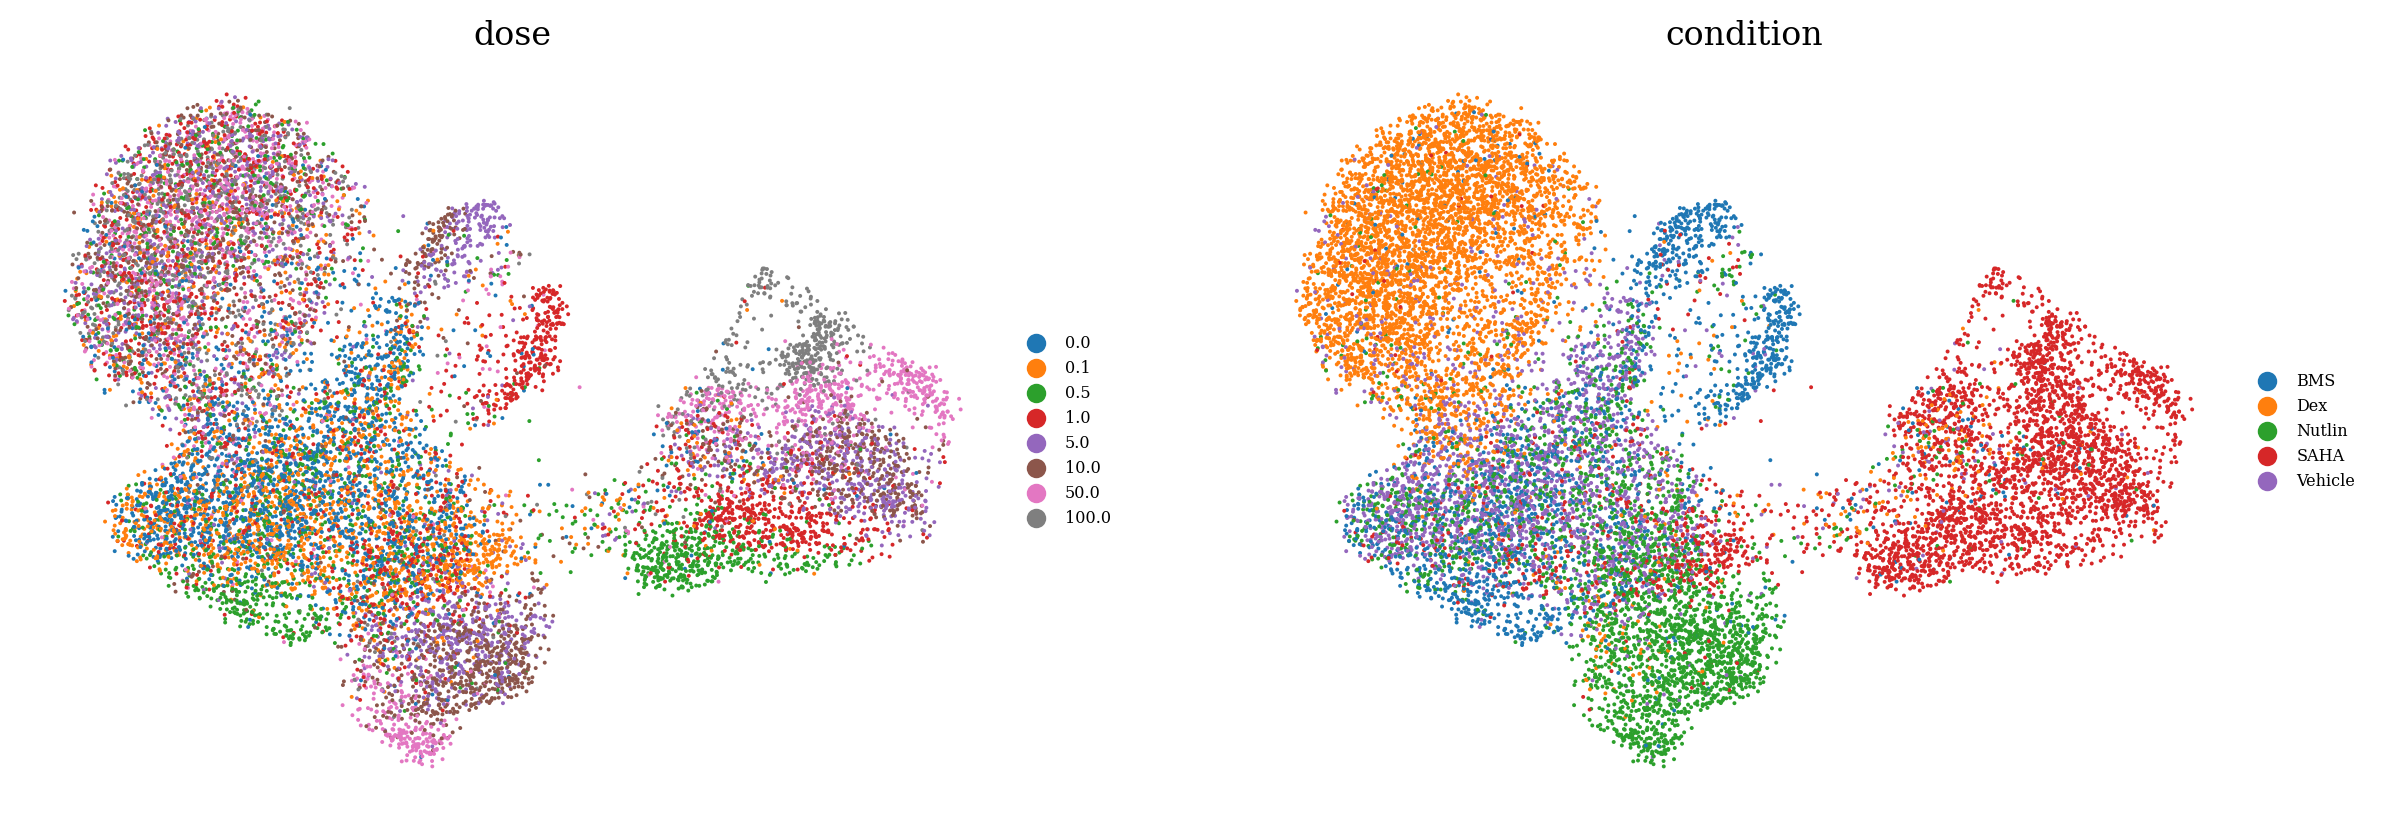

In [20]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

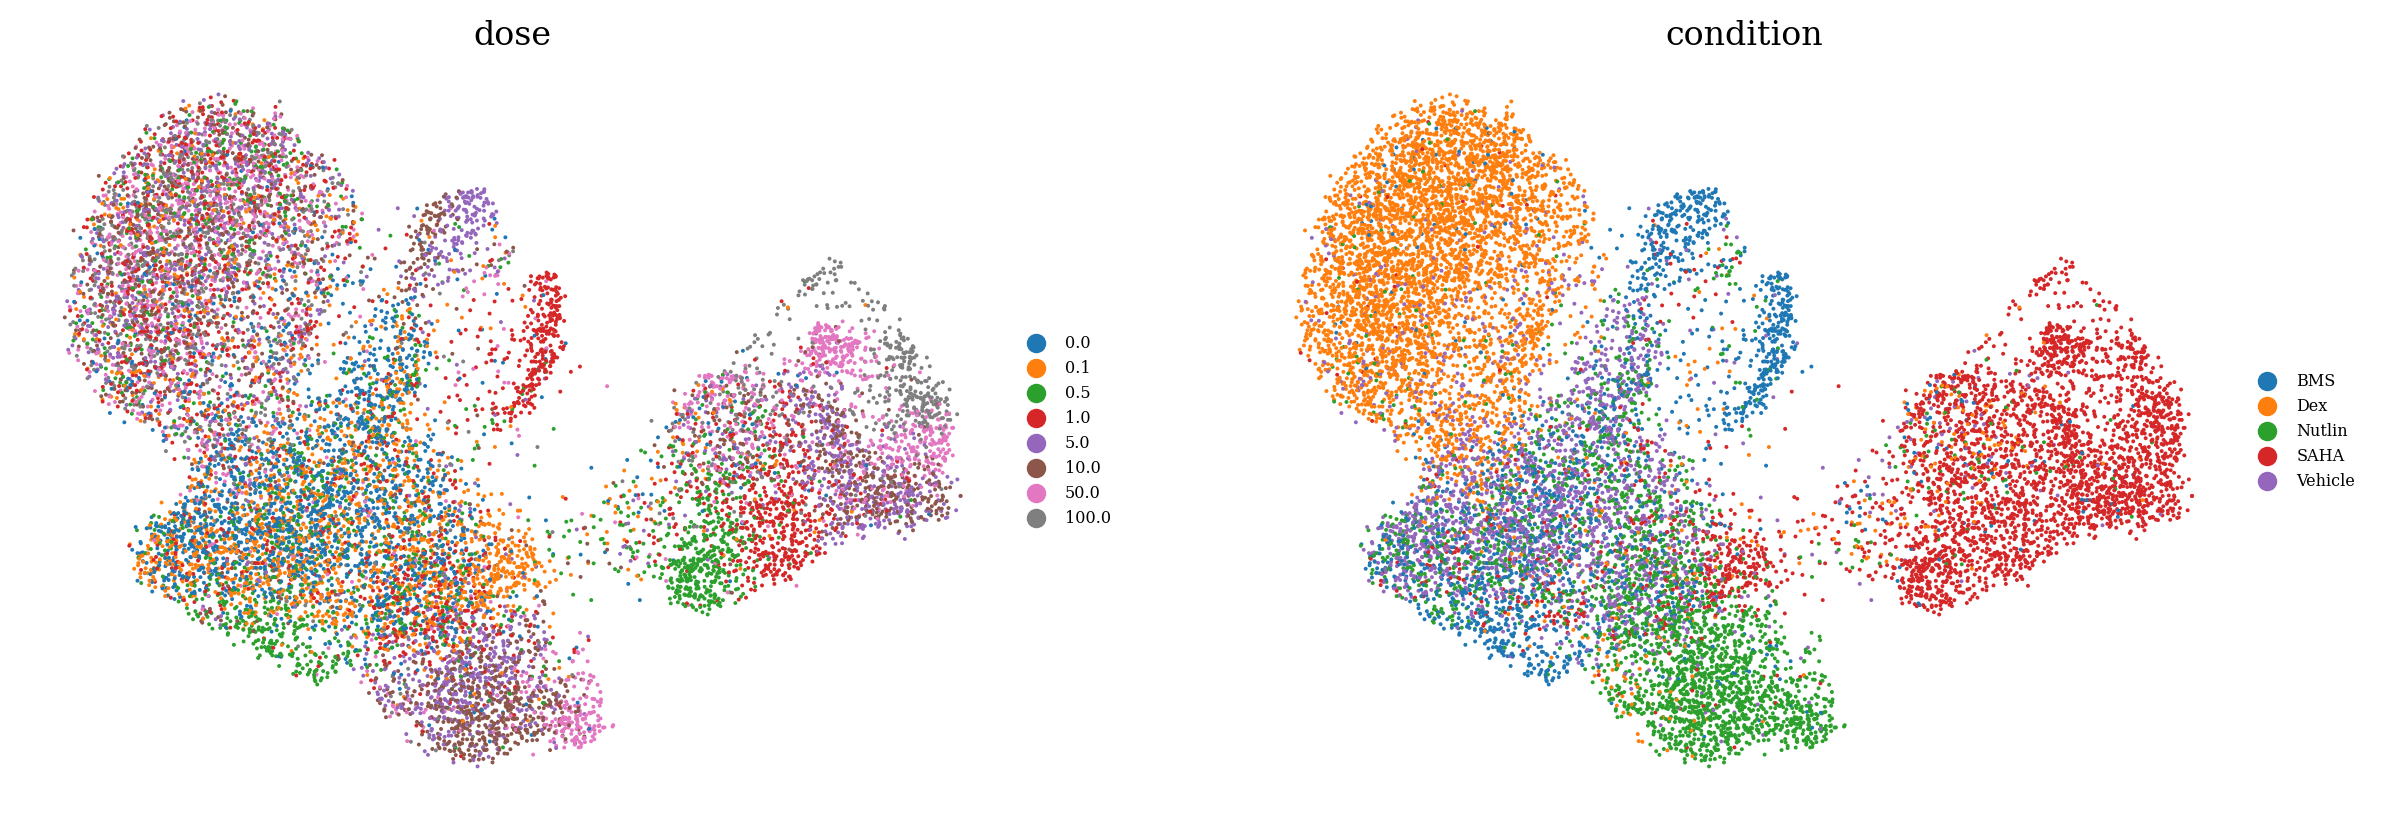

In [21]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [22]:
model.predict()

  0%|          | 0/463 [00:00<?, ?it/s]

  3%|▎         | 15/463 [00:00<00:03, 148.74it/s]

  8%|▊         | 36/463 [00:00<00:02, 183.36it/s]

 13%|█▎        | 61/463 [00:00<00:01, 211.82it/s]

 19%|█▊        | 86/463 [00:00<00:01, 226.13it/s]

 24%|██▍       | 111/463 [00:00<00:01, 234.40it/s]

 29%|██▉       | 136/463 [00:00<00:01, 239.03it/s]

 35%|███▍      | 161/463 [00:00<00:01, 241.85it/s]

 40%|████      | 186/463 [00:00<00:01, 242.62it/s]

 46%|████▌     | 211/463 [00:00<00:01, 244.21it/s]

 51%|█████     | 236/463 [00:01<00:00, 245.19it/s]

 56%|█████▋    | 261/463 [00:01<00:00, 245.75it/s]

 62%|██████▏   | 286/463 [00:01<00:00, 246.50it/s]

 67%|██████▋   | 311/463 [00:01<00:00, 247.00it/s]

 73%|███████▎  | 336/463 [00:01<00:00, 247.64it/s]

 78%|███████▊  | 361/463 [00:01<00:00, 248.13it/s]

 83%|████████▎ | 386/463 [00:01<00:00, 247.82it/s]

 89%|████████▉ | 411/463 [00:01<00:00, 247.72it/s]

 94%|█████████▍| 436/463 [00:01<00:00, 247.43it/s]

100%|█████████▉| 461/463 [00:01<00:00, 245.42it/s]

100%|██████████| 463/463 [00:01<00:00, 239.56it/s]

In [23]:
pred_adata = adata[model.test_indices].copy()
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [24]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.9823691825818225

In [25]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)